In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm

In [171]:
df = pd.read_csv('/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Merged Monthly Stock Data1.csv')
#df = pd.read_csv("/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Merged Monthly Stock Data.csv")


df = df.dropna()
df.tail()


,Date,bovprice,bovreturn,snpprice,snpreturn,election_month,before_election,after_election
299,5/1/99,"11,090",-2.30%,"1,301.80",-2.50%,0.0,0.0,0.0
300,4/1/99,"11,351",6.12%,"1,335.20",3.79%,0.0,0.0,0.0
301,3/1/99,"10,696",20.03%,"1,286.40",3.88%,0.0,0.0,0.0
302,2/1/99,"8,911",9.06%,"1,238.30",-3.23%,0.0,0.0,0.0
303,1/1/99,"8,171",20.45%,"1,279.60",4.10%,0.0,0.0,0.0


In [172]:
# Convert 'bovprice' and 'snpprice' to numeric types
df['bovprice'] = df['bovprice'].str.replace(',', '').astype(float)
df['snpprice'] = df['snpprice'].str.replace(',', '').astype(float)
df['bovreturn'] = df['bovreturn'].str.replace('%', '').astype(float)
df['snpreturn'] = df['snpreturn'].str.replace('%', '').astype(float)


In [173]:
T = len(df['Date'])
T



304

In [174]:
# Reverse the order of the dataframe
df = df[::-1]
date = pd.date_range(start='1999-01-01', periods=T, freq='1m')


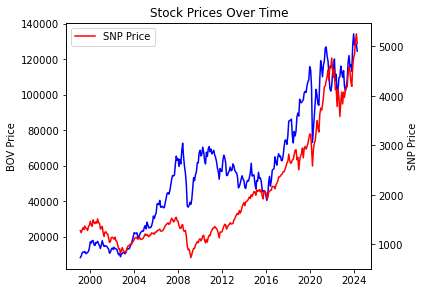

In [175]:



# Plotting
fig, ax1 = plt.subplots()

# Plot 'bovprice' on the primary y-axis
ax1.plot(date, df['bovprice'], color='blue', label='BOV Price')
ax1.set_ylabel('BOV Price')

# Create a secondary y-axis for 'snpprice'
ax2 = ax1.twinx()
ax2.plot(date, df['snpprice'], color='red', label='SNP Price')
ax2.set_ylabel('SNP Price')

plt.tight_layout()
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

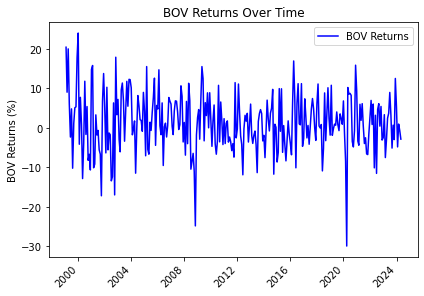

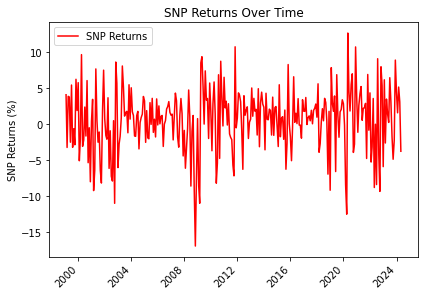

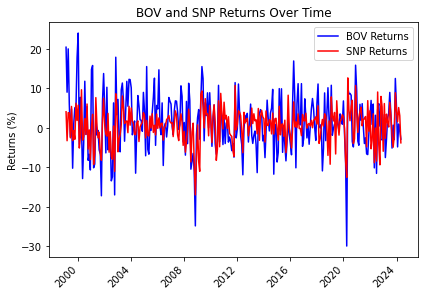

In [176]:
# Plotting BOV Returns
fig, ax1 = plt.subplots()
ax1.plot(date, df['bovreturn'], color='blue', label='BOV Returns')
ax1.set_ylabel('BOV Returns (%)')
plt.xticks(rotation=45, ha='right')  # Format x-axis labels
plt.tight_layout()
plt.title('BOV Returns Over Time')
plt.legend()
plt.show()
# Plotting SNP Returns
fig, ax2 = plt.subplots()
ax2.plot(date, df['snpreturn'], color='red', label='SNP Returns')
ax2.set_ylabel('SNP Returns (%)')
plt.xticks(rotation=45, ha='right')  # Format x-axis labels
plt.tight_layout()
plt.title('SNP Returns Over Time')
plt.legend()
plt.show()
# Plotting BOV Returns and SNP Returns on the same graph
fig, ax = plt.subplots()
ax.plot(date, df['bovreturn'], color='blue', label='BOV Returns')
ax.plot(date, df['snpreturn'], color='red', label='SNP Returns')
ax.set_ylabel('Returns (%)')
plt.xticks(rotation=45, ha='right')  # Format x-axis labels
plt.tight_layout()
plt.title('BOV and SNP Returns Over Time')
plt.legend()
plt.show()


<Figure size 720x360 with 0 Axes>

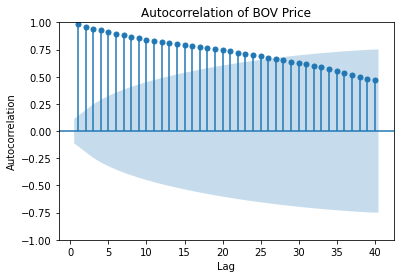

<Figure size 720x360 with 0 Axes>

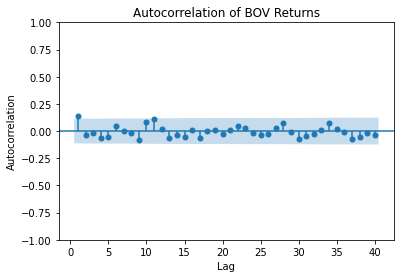

<Figure size 720x360 with 0 Axes>

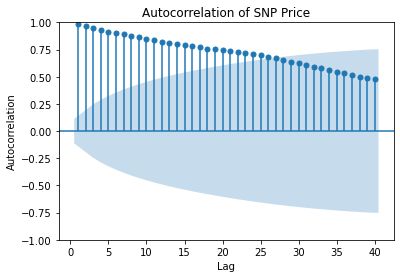

<Figure size 720x360 with 0 Axes>

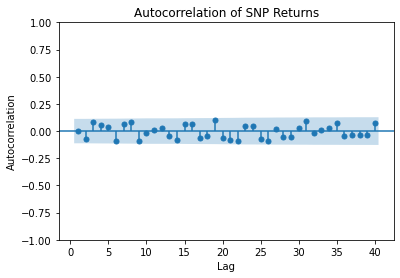

In [177]:
# Plot Correlogram for BOV Price
plt.figure(figsize=(10, 5))
plot_acf(df['bovprice'], lags=40, zero=False, title='Autocorrelation of BOV Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for BOV Returns
plt.figure(figsize=(10, 5))
plot_acf(df['bovreturn'].dropna(), lags=40, zero=False, title='Autocorrelation of BOV Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for SNP Price
plt.figure(figsize=(10, 5))
plot_acf(df['snpprice'], lags=40, zero=False, title='Autocorrelation of SNP Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for SNP Returns
plt.figure(figsize=(10, 5))
plot_acf(df['snpreturn'].dropna(), lags=40, zero=False, title='Autocorrelation of SNP Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [186]:
# Lag effect estimation Regression
def estimate_lag_effect(ts, lags):
    """
    Estimates the effect of lagged values on the current value of a time series.
    
    Parameters:
    - ts (pandas.Series or numpy.ndarray): The time series data.
    - lags (int): The number of lagged terms to include in the model. Must be non-negative.
    
    Returns:
    - result (RegressionResults): The regression results object from statsmodels.
    """
    if not isinstance(lags, int) or lags < 0:
        raise ValueError("lags must be a non-negative integer")

    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    
    if len(ts) <= lags:
        raise ValueError("Time series is too short relative to the number of lags requested")
    
    df = pd.concat([ts.shift(i) for i in range(lags + 1)], axis=1)
    df.columns = ['y'] + [f'lag_{i}' for i in range(1, lags + 1)]
    df = df.dropna()

    X = df.drop(columns='y')
    X = sm.add_constant(X)
    y = df['y']
    
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result


ADF Statistic: -12.119517649892703
p-value: 1.8390674113899946e-22
Critical Values:
	1%: -3.4521902441030963
	5%: -2.871158406898617
	10%: -2.5718948388228586
                            AutoReg Model Results                             
Dep. Variable:              bovreturn   No. Observations:                  304
Model:                     AutoReg(1)   Log Likelihood               -1025.584
Method:               Conditional MLE   S.D. of innovations              7.141
Date:                Thu, 02 May 2024   AIC                           2057.168
Time:                        17:39:22   BIC                           2068.309
Sample:                             1   HQIC                          2061.625
                                  304                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9966      0.416      2.395  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


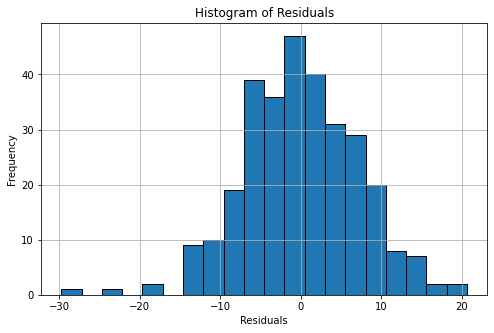

In [195]:
result = adfuller(df['bovreturn'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# If 'bovreturn' is not stationary, apply differencing or other transformations to make it stationary
# For example, you can use df1['bovreturn_diff'] = df1['bovreturn'].diff().dropna()

# Define lag order (p) for the AR model
p = 1 # Example lag order

# Fit AR model
model = AutoReg(df['bovreturn'], lags=p)
results = model.fit()

# Print model summary
print(results.summary())


residuals = results.resid

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()


In [197]:
#figure out how to get se of regression and dependent variable next

SyntaxError: invalid syntax (3027992189.py, line 1)

In [ ]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1
